# Hyperparameter search over CNN model based on 5-fold cross-validation

User c is completely removed as this is the test set.

The remaining users A,B,D,E and F make up each fold.

For example, fold 1 will train on users B,D,E and F then evaluate on A (and so on for each fold).

Choice of model (16-32) justified from "7_CNN_model_comparison.ipynb"

## Notebook setup

Allow editing of modules using editor (auto reloading)

In [0]:
# Needed to allow editing using PyCharm etc
%load_ext autoreload
%autoreload 2

The following cell is needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [2]:
import os
path = os.getcwd()
if path == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
#     !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif path == 'D:\\Google Drive\\Level-4-Project\\notebooks':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
elif path == "/export/home/2192793m":
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
DATA_PATH = BASE_PATH + 'data/processed/doppler_spectrograms/3/'

RESULTS_PATH = BASE_PATH + 'results/CNN_hyperparameter_search/'
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)
   

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Import remaining packages

In [3]:
import numpy as np
import sys
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix
import csv
from keras.models import load_model
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
# needed for CheckpointSaver
# https://github.com/scikit-optimize/scikit-optimize/issues/678
! pip install git+https://github.com/scikit-optimize/scikit-optimize/ 
    
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.callbacks import CheckpointSaver
from skopt import dump, load
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations

  Cloning https://github.com/scikit-optimize/scikit-optimize/ to /tmp/pip-req-build-op0t047h
  Stored in directory: /tmp/pip-ephem-wheel-cache-x0yp46bx/wheels/66/66/b5/e1160753c1f4d7763be2755539df2c2ebd6e50f987dbea6abf
Successfully built scikit-optimize


### Check this cell

In [0]:
# Needed as originally code was for theano backend but now using tensor flow
from keras import backend as K
K.set_image_dim_ordering('th')

## Experiment Setup

In [0]:
target_names = ["walking", "pushing", "sitting", "pulling",
                "circling", "clapping", "bending"]
nb_classes = len(target_names)

# input image dimensions
img_rows, img_cols = 75, 75
# user c excluded as this is reserved for final evaluation
users = ["A", "B", "D", "E", "F"] 

In [0]:
def load_data(user_letter):
    with open(DATA_PATH + user_letter + "_data.pkl", 'rb') as data_file:
        data = pickle.load(data_file)
        data = data.reshape(data.shape[0], 1, 75, 75)
        
    with open(DATA_PATH + user_letter + "_labels.pkl", 'rb') as labels_file:
        labels = pickle.load(labels_file)
        labels = np.reshape(labels, (len(labels), 1))

        
    return data, labels

In [0]:
datasets = {}
for user in users:
    data, labels = load_data(user)
    datasets[user] = {"data":data, "labels":labels}

In [0]:
def split_train_validation(validation_user):
    train_data = None
    train_labels = None
    first_round = True
    validation_data = []
    validation_labels = []
    for user in users:
        data = datasets[user]["data"]
        labels = datasets[user]["labels"]
        if user == validation_user:
            validation_data = data
            validation_labels = labels
            
        else:
            if first_round:
                train_data = data
                train_labels = labels
                first_round = False
            else:
                train_data = np.concatenate((train_data, data))
                train_labels = np.concatenate((train_labels, labels))
            
    train_labels = np_utils.to_categorical(train_labels, nb_classes)
    validation_labels = np_utils.to_categorical(validation_labels, nb_classes)
    train_data = train_data.astype('float32')
    validation_data = validation_data.astype('float32')
    train_data /= 255
    validation_data /= 255 
    
    return {
        "train_data": train_data,
        "train_labels": train_labels,
        "validation_data": validation_data,
        "validation_labels": validation_labels
       }

## Define Model

In [0]:
def make_model(nb_filters, img_rows, img_cols, nb_classes, activation,
               dropout, num_dense_nodes, num_dense_layers,
               kernel_size, pooling_size):
    
    kernel_size = (kernel_size, kernel_size)
    pooling_size = (pooling_size, pooling_size)
    
    model = Sequential(name=nb_filters)
    nb_filters = nb_filters.split("-")
    size_1 = int(nb_filters[0])
    size_2 = int(nb_filters[1])

    model.add(Convolution2D(size_1, kernel_size, padding='same',
                            input_shape=(1, img_rows, img_cols),
                            activation=activation))
    model.add(Convolution2D(size_1, kernel_size, activation=activation))
    model.add(MaxPooling2D(pool_size=pooling_size))
    model.add(Dropout(dropout))

    model.add(Convolution2D(size_2, kernel_size, padding='same',
                            activation=activation))
    model.add(Convolution2D(size_2, kernel_size, activation=activation))
    model.add(MaxPooling2D(pool_size=pooling_size))
    model.add(Dropout(dropout))

    model.add(Flatten())
    for i in range(num_dense_layers):
        model.add(Dense(num_dense_nodes, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(nb_classes, activation='softmax'))
    return model

## Hyperparameter Search

### Fixed Parameters

In [0]:
nb_epoch = 30 # 30

### Parameters to Search

In [0]:
space = [
    Categorical(['adam', 'sgd_standard', 'sgd_nestrov'], name='optimizer'),
    Real(0.0001, 0.1, "log-uniform", name='learning_rate'),
    Categorical(['relu', 'sigmoid', 'tanh'], name='activation'),
    Real(0.1, 0.9, name='dropout'),
    Integer(16, 1024, name='num_dense_nodes'),
    Integer(1,3, name='num_dense_layers'),
    Integer(2,5, name='kernel_size'),
    Integer(2,4, name='pooling_size'),
    Integer(8, 1024, name='batch_size')
]

### Objective Function to Minimize

In [0]:
@use_named_args(space)
def objective(**params):
    average_accuracy = 0
    average_loss = 0
    for user in users:
        data_split = split_train_validation(user)
        train_data = data_split["train_data"]
        train_labels = data_split["train_labels"]
        validation_data = data_split["validation_data"]
        validation_labels = data_split["validation_labels"]

        model = make_model("16-32", img_rows, img_cols, nb_classes,
                           params["activation"], params['dropout'],
                           params['num_dense_nodes'],
                           params['num_dense_layers'], params['kernel_size'],
                           params['pooling_size'])
        if params['optimizer'] == 'adam':
            selected_optimizer = Adam(lr=params['learning_rate'])
            
        elif params['optimizer'] == 'sgd_standard':
            selected_optimizer = SGD(lr=params['learning_rate'])
            
        else:
            #nestrov momentum
            selected_optimizer = SGD(lr=params['learning_rate'], decay=1e-6, 
                                     momentum=0.9, nesterov=True)
            
        model.compile(loss='categorical_crossentropy',
                      optimizer=selected_optimizer,
                      metrics=['accuracy'])

        model.fit(
            train_data,
            train_labels,
            batch_size=params['batch_size'],
            epochs=nb_epoch,
            shuffle=True, 
            verbose=1)

        evaluation = model.evaluate(validation_data, validation_labels,
                                    batch_size=params['batch_size'], verbose=0)

        average_loss += evaluation[0]
        average_accuracy += evaluation[1]
        
    return -(average_accuracy/len(users)) # return negative as minimizing

### Callbacks

In [0]:
checkpoint = CheckpointSaver(RESULTS_PATH + "res_gp_checkpoint.pkl")
callbacks_list = [checkpoint]

### Load checkpoint

In [0]:
LOAD_CHECKPOINT = True

In [0]:
if LOAD_CHECKPOINT:
    res = load(RESULTS_PATH + "res_gp_checkpoint.pkl")
    x0 = res.x_iters
    y0 = res.func_vals
    
else:
    x0 = None
    y0 = None

### Perform Search

In [0]:
res_gp = gp_minimize(objective, space, x0=x0, y0=y0,
                     n_calls=130, n_random_starts=10,
                     random_state=0, callback=callbacks_list)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0011
Function value obtained: -0.8426
Current minimum: -0.8534
Iteration No: 2 started. Evaluating function at random point.
Epoch 1/30
29019/29019 [==============================] - 13s 464us/step - loss: 1.8181 - acc: 0.2709
Epoch 2/30
29019/29019 [==============================] - 13s 432us/step - loss: 1.2549 - acc: 0.5061
Epoch 3/30
29019/29019 [==============================] - 12s 417us/step - loss: 0.9262 - acc: 0.6364
Epoch 4/30
29019/29019 [==============================] - 12s 412us/step - loss: 0.7285 - acc: 0.7149
Epoch 5/30
29019/29019 [==============================] - 12s 414us/step - loss: 0.6402 - acc: 0.7583
Epoch 6/30
29019/29019 [==============================] - 12s 412us/step - loss: 0.5812 - acc: 0.7815
Epoch 7/30
29019/29019 [==============================] - 12s 412us/step - loss: 0.5432 - acc: 0.7978
Epoch 8/30
29019/29019 [=====

KeyboardInterrupt: ignored

### Save gp results

In [0]:
dump(res_gp, RESULTS_PATH + "res_gp_complete.pkl")

### Load gp results

In [0]:
res_gp = load(RESULTS_PATH + "res_gp_complete.pkl")

## Results

In [0]:
# params at minimum
res_gp.x

In [0]:
print("Accuracy:", -res_gp.fun)

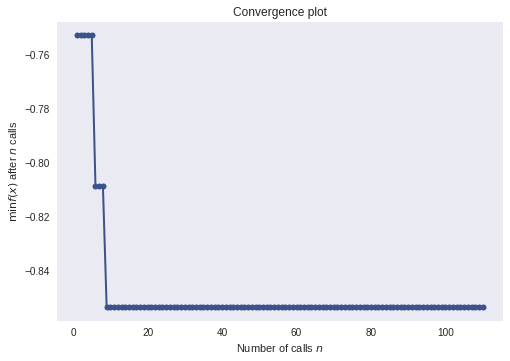

In [9]:
plot_convergence(res)

In [0]:
res.x

['adam', 0.0022567198219888875, 'relu', 0.4533687369990764, 1003, 2, 3, 3, 903]

In [0]:
-res.fun

0.8533712718484943

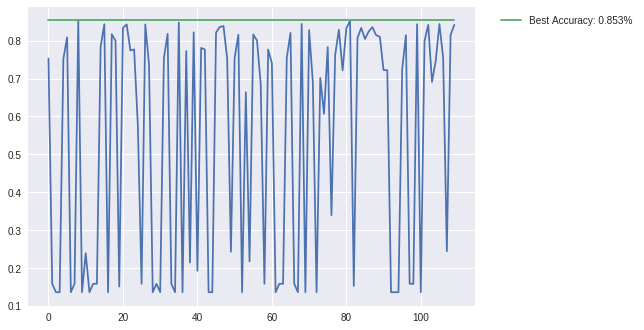

In [10]:
plt.plot(-res.func_vals)
plt.plot(np.full((len(res.func_vals)), -res.fun), label="Best Accuracy: " + str(round(-res.fun, 3))+"%")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [0]:
res.x_iters

[['sgd_standard',
  0.0341033659841376,
  'tanh',
  0.7778013910273005,
  645,
  2,
  3,
  2,
  285],
 ['sgd_standard',
  0.027321603619774242,
  'sigmoid',
  0.4142278368806639,
  859,
  2,
  4,
  3,
  980],
 ['adam',
  0.040762590410962536,
  'sigmoid',
  0.7407286015837156,
  541,
  2,
  4,
  3,
  554],
 ['sgd_nestrov',
  0.00020783697921338129,
  'sigmoid',
  0.249065874661408,
  759,
  1,
  2,
  3,
  160],
 ['adam',
  0.0014436667144263008,
  'tanh',
  0.4599599919289822,
  634,
  3,
  2,
  4,
  672],
 ['adam',
  0.0011870158031597254,
  'tanh',
  0.5862645349723743,
  344,
  1,
  4,
  4,
  671],
 ['sgd_standard',
  0.09680520367410021,
  'sigmoid',
  0.43149487058109515,
  494,
  2,
  3,
  3,
  330],
 ['sgd_nestrov',
  0.07058512048254183,
  'sigmoid',
  0.11085730848968788,
  644,
  2,
  5,
  4,
  526],
 ['adam',
  0.0022567198219888875,
  'relu',
  0.4533687369990764,
  1003,
  2,
  3,
  3,
  903],
 ['sgd_nestrov',
  0.0004471635680750561,
  'sigmoid',
  0.7920820490443082,
  5

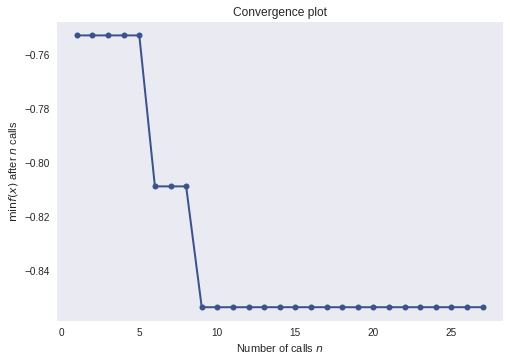

In [0]:
plot_convergence(res_gp)

In [0]:
# dimensions = ['optimizer', 'learning_rate', 'activation', 'dropout',
#               'num_dense_nodes', 'num_dense_layers', 'kernel_size',
#               'pooling_size','batch_size']

# for dimension in dimensions:
#     plot_histogram(result=res_gp,
#                    dimension_name=dimension)